In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from numpy import zeros_like
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd
import scipy.stats as ss

sympy.init_printing()

# Process

In [11]:
def merton_jump_paths(S0, T, r, sigma,  lam, m, v, steps, Npaths):
    size=(steps,Npaths)
    dt = T/steps 
    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size), np.random.normal(m,v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((r -  sigma**2/2 -lam*(m  + v**2*0.5))*dt + sigma*np.sqrt(dt) * np.random.normal(size=size)), axis=0)
    return np.exp(geo+poi_rv)*S0

def merton_jump_to_ruin_paths(S0, T, r, sigma, lam, steps, Npaths):
    size = (steps, Npaths)
    dt = T/steps
    jump_indices = np.random.poisson(lam*dt, size=size)
    ruin_indices = np.cumsum(jump_indices, axis=0) > 0  # Identify points after the jump

    # Geometric Brownian Motion component
    geo = np.cumsum((r - sigma**2/2)*dt + sigma*np.sqrt(dt) * np.random.normal(size=size), axis=0)

    # Combine and apply the ruin effect
    stock_paths = np.exp(geo)*S0
    stock_paths[ruin_indices] = 0  # Set to zero after the jump
    return stock_paths

In [19]:
K = 100
S0 = 103

mu = 0.02
N = 1
I = 250
Npaths = 10
m = 0
T = 1

GBM_lam = 0
GBM_sigma = 0.04
GBM_mu = mu
GBM_v = 0

LN_lam = 1
LN_sigma = 0.02
LN_mu = mu
LN_v = 0.04

JR_lam = 0.01
JR_sigma = 0.03
JR_mu = 0.01

df = np.exp(-mu*T)

GBM = merton_jump_paths(100, T, mu, GBM_sigma, GBM_lam, GBM_mu, GBM_v, I, Npaths)
LN = merton_jump_paths(100, T, mu, LN_sigma, LN_lam, LN_mu, LN_v, I, Npaths)
JR = merton_jump_to_ruin_paths(100, T, mu, JR_sigma, JR_lam, I, Npaths)

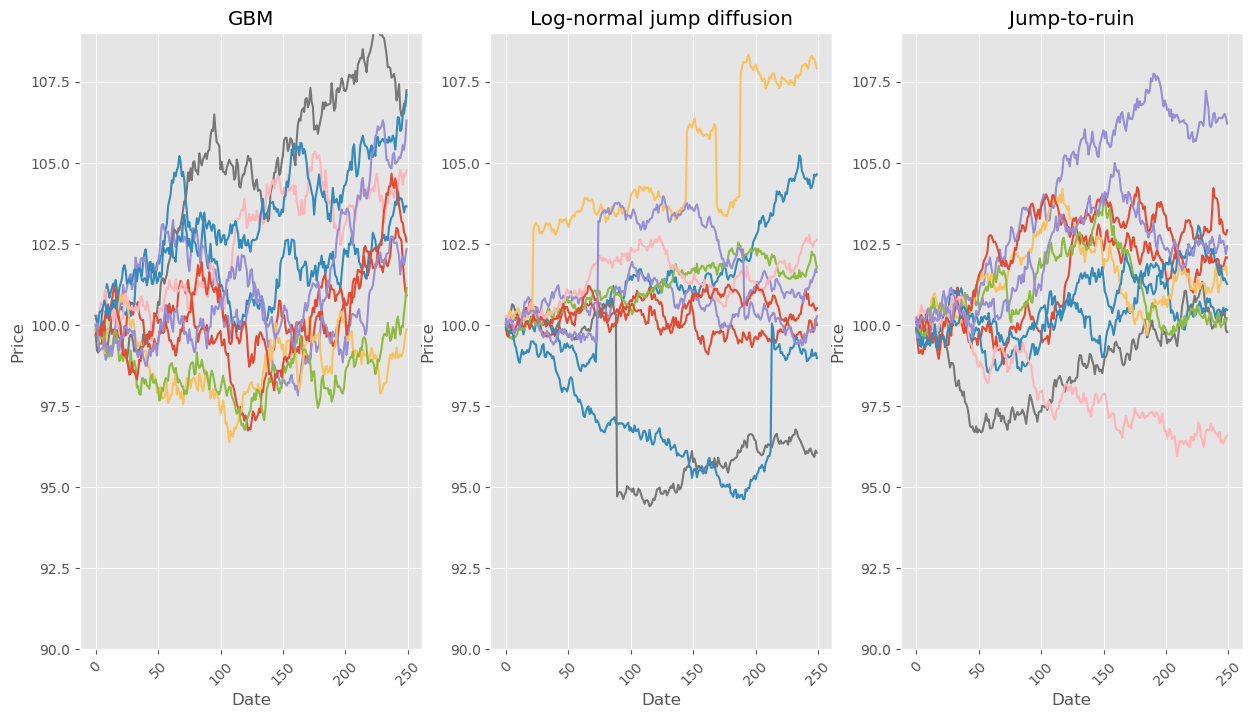

In [20]:
if Npaths < 101:
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))

    axs[0].plot(GBM, lw=1.5)
    axs[0].set_title("GBM")
    axs[0].set_xlabel("Date")
    axs[0].set_ylabel("Price")
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].set_ylim([90, 109])  # Set y-axis range from 90 to 109

    axs[1].plot(LN, lw=1.5)
    axs[1].set_title("Log-normal jump diffusion")
    axs[1].set_xlabel("Date")
    axs[1].set_ylabel("Price")
    axs[1].tick_params(axis='x', rotation=45)
    axs[1].set_ylim([90, 109])  # Set y-axis range from 90 to 109

    axs[2].plot(JR, lw=1.5)
    axs[2].set_title("Jump-to-ruin")
    axs[2].set_xlabel("Date")
    axs[2].set_ylabel("Price")
    axs[2].tick_params(axis='x', rotation=45)
    axs[2].set_ylim([90, 109])  # Set y-axis range from 90 to 109

# LSM

In [14]:
def LSM(K, S, I, df, basis, deg):
    paths = len(S)
    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1] # set value at maturity equal to intrinsic value
    np.random.seed(1)
    # Valuation by LS Method
    for t in range(I - 2, 0, -1): #start at t = I-2 and go backwards (since we already set t = I-1 to intrinsic value)
        good_paths = H[:, t] > 0  # paths where the intrinsic value is positive
        # the regression is performed only on these paths
        if basis == 'poly':
            if np.sum(good_paths) > 0:
                rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polyval(rg, S[good_paths, t])
            else:
                continue
        elif basis == 'legendre':
            if np.sum(good_paths) > 0:
                rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.legendre.legval(S[good_paths, t], rg)
            else:
                continue
        elif basis =='laguerre':
            if np.sum(good_paths) > 0:
                rg = np.polynomial.laguerre.lagfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.laguerre.lagval(S[good_paths, t], rg)
            else:
                continue
        else:
            if np.sum(good_paths) > 0:
                rg = np.polynomial.hermite.hermfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.hermite.hermval(S[good_paths, t], rg)
            else:
                continue

        exercise = np.zeros(len(good_paths), dtype=bool)  # initialize
        exercise[good_paths] = H[good_paths, t] > C  # paths where it is optimal to exercise

        V[exercise, t] = H[exercise, t]  # set V equal to H where it is optimal to exercise
        V[exercise, t + 1 :] = 0  # set future cash flows, for that path, equal to zero
        discount_path = V[:, t] == 0  # paths where we didn't exercise
        V[discount_path, t] = V[discount_path, t + 1] * df  # set V[t] in continuation region

    V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
    V0_array = V[:, 1] * df
    SE = np.std(V[:, 1] * df) / np.sqrt(paths)
    return V0, V0_array, SE

In [15]:
deg = 3
basis = 'legendre'
#initial price list
S0_list = np.arange(97, 104 , 1)

In [16]:
GBM_price, GBM_V, GBM_SE = LSM(K, GBM.T, I, df, basis, deg)
LN_price, LN_V, LN_SE = LSM(K, LN.T, I, df, basis, deg)
JR_price, JR_V, JR_SE = LSM(K, JR.T, I, df, basis, deg)

In [17]:
#fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) # Adjust the figsize as needed
#
#axes[0].hist(GBM_V, bins=50)
#axes[0].set_title('GBM')
#
#axes[1].hist(LN_V, bins=50)
#axes[1].set_title('Merton')
#
#axes[2].hist(JR_V, bins=50)
#axes[2].set_title('Drop')
#
#plt.tight_layout() # This ensures that the subplots fit nicely in the figure area
#plt.show()

In [18]:
# Containers for storing matrices
GBM_matrices = {}
LN_matrices = {}
JR_matrices = {}

# Containers for storing prices
GBM_prices = []
LN_prices = []
JR_prices = []

GBM_SE = []
LN_SE = []
JR_SE = []

# Generate matrices and calculate prices for each S0 in S0_list
for S0 in S0_list:
    # Generate matrices
    GBM = merton_jump_paths(S0, T, mu, GBM_sigma, GBM_lam, GBM_mu, GBM_v, I, Npaths)
    LN = merton_jump_paths(S0, T, mu, LN_sigma, LN_lam, LN_mu, LN_v, I, Npaths)
    JR = merton_jump_to_ruin_paths(S0, T, mu, JR_sigma, JR_lam, I, Npaths)

    # Calculate prices for each stock model
    GBM_price, GBM_V, SE_GBM = LSM(K, GBM, I, df, basis, deg)
    LN_price, LN_V, SE_LN = LSM(K, LN, I, df, basis, deg)
    JR_price, JR_, SE_JR = LSM(K, JR, I, df, basis, deg)

    # Store the prices
    GBM_prices.append(GBM_price)
    LN_prices.append(LN_price)
    JR_prices.append(JR_price)

    #store the standard errors
    GBM_SE.append(SE_GBM)
    LN_SE.append(SE_LN)
    JR_SE.append(SE_JR)

IndexError: index 248 is out of bounds for axis 1 with size 100

In [ ]:
def closed_formula_GBM(S0, mu, sigma, T, K):
    """
    Black Scholes closed formula:
    """
    d1 = (np.log(S0 / K) + (mu + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-mu * T) * ss.norm.cdf(-d2) - S0 * ss.norm.cdf(-d1)

def closed_formula_GBM_call(S0, mu, sigma, T, K):
    """
    Black Scholes closed formula:
    """
    d1 = (np.log(S0 / K) + (mu + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * ss.norm.cdf(d1) - K * np.exp(-mu * T) * ss.norm.cdf(d2)

def closed_formula_LN(S0):
    m = LN_lam * (np.exp(LN_mu + (LN_sigma**2) / 2) - 1)
    lam2 = LN_lam * np.exp(LN_mu + LN_sigma**2) / 2
    v = LN_v

    tot = 0
    for k in range(18):
        tot += (np.exp(-lam2 * T) * (lam2 * T) ** k / np.math.factorial(k)) * closed_formula_GBM(
        S0,
        LN_mu - m + k * (LN_mu + 0.5 * LN_sigma**2) / T,
        np.sqrt(LN_sigma**2 + k * v**2 / T),
        T,
        K
        )
        return tot
    
def closed_formula_Call_JR(S0):
    return np.exp(-JR_lam * T) * closed_formula_GBM_call(S0, JR_mu, JR_sigma, T, K)

def closed_formula_Put_JR(S0):
    return closed_formula_Call_JR(S0) - S0 + K * np.exp(-JR_mu * T)

In [ ]:
# Print the V0 price for each model and each S0
for i, S0 in enumerate(S0_list):
    print(f"S0 = {S0}:")
    print(f"  GBM Price: {GBM_prices[i]},   se = {GBM_SE[i]}")
    print(f"  Merton Price: {LN_prices[i]},  se = {LN_SE[i]}")
    print(f"  Drop Price: {JR_prices[i]}, se = {JR_SE[i]}")
    print(f"  European_GBM: {closed_formula_GBM(S0, GBM_mu, GBM_sigma, T, K)}")
    print(f"  European_LN: {closed_formula_LN(S0)}")
    print(f"  European_JR: {closed_formula_Put_JR(S0)}")
    print()

S0 = 97:
  GBM Price: 0.000288667360386967,   se = 4.894144345919856e-07
  Merton Price: 0.00029320537192583556,  se = 2.9030807268491535e-07
  Drop Price: 0.0002903723394598261, se = 7.691870741893047e-07
  European_GBM: 2.118745615167974
  European_LN: 1.856664264805681
  European_JR: 2.4336746648261425

S0 = 98:
  GBM Price: 0.00019221391678933352,   se = 4.3781672495402937e-07
  Merton Price: 0.0001941969282454984,  se = 3.334339336816451e-07
  Drop Price: 0.0001923804109790567, se = 1.0302448854818696e-06
  European_GBM: 1.5738617406084288
  European_LN: 1.3184061133164857
  European_JR: 1.7414688568398162

S0 = 99:
  GBM Price: 9.939619052173405e-05,   se = 3.5857387920863375e-07
  Merton Price: 9.791186955339305e-05,  se = 2.7461854763697924e-07
  Drop Price: 9.749106481169172e-05, se = 8.773988419287265e-07
  European_GBM: 1.1301920187930676
  European_LN: 0.8526937136501547
  European_JR: 1.1755726989986357

S0 = 100:
  GBM Price: 3.309575414093876e-05,   se = 2.36980131733209

In [ ]:
def LSM(K, S, I, df, basis, deg):
    paths = len(S)
    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1] # set value at maturity equal to intrinsic value
    np.random.seed(1)
    # Valuation by LS Method
    for t in range(I - 2, 0, -1): #start at t = I-2 and go backwards (since we already set t = I-1 to intrinsic value)
        good_paths = H[:, t] > 0  # paths where the intrinsic value is positive
        # the regression is performed only on these paths
        if basis == 'poly':
            if np.sum(good_paths) > 0:
                rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polyval(rg, S[good_paths, t])
            else:
                continue
        elif basis == 'legendre':
            if np.sum(good_paths) > 0:
                rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.legendre.legval(S[good_paths, t], rg)
            else:
                continue
        elif basis =='laguerre':
            if np.sum(good_paths) > 0:
                rg = np.polynomial.laguerre.lagfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.laguerre.lagval(S[good_paths, t], rg)
            else:
                continue
        else:
            if np.sum(good_paths) > 0:
                rg = np.polynomial.hermite.hermfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.hermite.hermval(S[good_paths, t], rg)
            else:
                continue

        exercise = np.zeros(len(good_paths), dtype=bool)  # initialize
        exercise[good_paths] = H[good_paths, t] > C  # paths where it is optimal to exercise

        V[exercise, t] = H[exercise, t]  # set V equal to H where it is optimal to exercise
        V[exercise, t + 1 :] = 0  # set future cash flows, for that path, equal to zero
        discount_path = V[:, t] == 0  # paths where we didn't exercise
        V[discount_path, t] = V[discount_path, t + 1] * df  # set V[t] in continuation region

    V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
    V0_array = V[:, 1] * df
    SE = np.std(V[:, 1] * df) / np.sqrt(paths)
    return V0, V0_array, SE

In [ ]:
def LSM(K, S, I, df, basis, deg):
    Npaths = S.shape[0]
    dt = T/I
    payoff = np.maximum(K - S, 0)
    dis_cfl = np.zeros_like(payoff)
    dis_cfl[:, -1] = payoff[:, -1]

    exercise_flag = np.zeros((Npaths, I))
    cond = S[:, -1] < K
    exercise_flag[cond, -1] = 1

    for i in range(I-2, 0, -1):  # Adjusted loop range
        cond = S[:, i] < K
        print(cond.sum(), 'paths has the option to exercise')
        X = np.column_stack([np.ones(Npaths), np.exp(-S[:, i]/2), np.exp(-S[:, i]/2)*(1-S[:, i]), np.exp(-S[:, i]/2)*(1-2*S[:, i]+S[:, i]**2/2)])
        cond_x = X[cond, :]
        Y = df * dis_cfl[cond, i+1]  # Future discounted cash flow
        beta = np.linalg.lstsq(cond_x, Y, rcond=None)[0]
        continue_val = X @ beta
        continue_val[~cond] = 0
        cond_exercise = payoff[:, i] > continue_val
        exercise_flag[cond_exercise, i] = 1
        dis_cfl[cond_exercise, i] = df * payoff[cond_exercise, i]
        stopping_criteria = np.argmax(exercise_flag, axis=1)
    actual_exercise = np.zeros_like(exercise_flag)
    actual_exercise[np.arange(Npaths), stopping_criteria] = exercise_flag[np.arange(Npaths), stopping_criteria]
    print(actual_exercise)
    discount = (np.ones((Npaths, I-1))*df).cumprod(axis=1)  # Adjusted for shape (Npaths, I-1)
    exp_payoff = (actual_exercise[:,1:] * payoff[:,1:] * discount).sum(axis=1) / Npaths  # Adjusted slicing for actual_exercise
    price = exp_payoff.mean()
    SE = exp_payoff.std() / np.sqrt(Npaths)

    print(price)

    return price, SE

In [ ]:
def closed_formula_GBM(S0, mu, sigma, T, K):
    """
    Black Scholes closed formula:
    """
    d1 = (np.log(S0 / K) + (mu + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-mu * T) * ss.norm.cdf(-d2) - S0 * ss.norm.cdf(-d1)

def closed_formula_GBM_call(S0, mu, sigma, T, K):
    """
    Black Scholes closed formula:
    """
    d1 = (np.log(S0 / K) + (mu + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * ss.norm.cdf(d1) - K * np.exp(-mu * T) * ss.norm.cdf(d2)

def closed_formula_LN(S0):
    m = LN_lam * (np.exp(LN_mu + (LN_sigma**2) / 2) - 1)
    lam2 = LN_lam * np.exp(LN_mu + LN_sigma**2) / 2
    v = LN_v

    tot = 0
    for k in range(18):
        tot += (np.exp(-lam2 * T) * (lam2 * T) ** k / np.math.factorial(k)) * closed_formula_GBM(
        S0,
        LN_mu - m + k * (LN_mu + 0.5 * LN_sigma**2) / T,
        np.sqrt(LN_sigma**2 + k * v**2 / T),
        T,
        K
        )
        return tot
    
def closed_formula_Call_JR(S0):
    return np.exp(-JR_lam * T) * closed_formula_GBM_call(S0, JR_mu, JR_sigma, T, K)

def closed_formula_Put_JR(S0):
    return closed_formula_Call_JR(S0) - S0 + K * np.exp(-JR_mu * T)

In [ ]:
GBM_price = LSM(K, GBM.T, I, df, basis, deg)
LN_price = LSM(K, LN.T, I, df, basis, deg)
JR_price = LSM(K, JR.T, I, df, basis, deg)


print(f"GBM price: {GBM_price}", f"European price: {closed_formula_GBM(S0, GBM_mu, GBM_sigma, T, K)}")
print(f"LN price: {LN_price}", f"European price: {closed_formula_LN(S0)}")
print(f"JR price: {JR_price}", f"European price: {closed_formula_Put_JR(S0)}")

1088 paths has the option to exercise
1083 paths has the option to exercise
1083 paths has the option to exercise
1084 paths has the option to exercise
1087 paths has the option to exercise
1081 paths has the option to exercise
1091 paths has the option to exercise
1106 paths has the option to exercise
1087 paths has the option to exercise
1090 paths has the option to exercise
1084 paths has the option to exercise
1077 paths has the option to exercise
1087 paths has the option to exercise
1077 paths has the option to exercise
1081 paths has the option to exercise
1084 paths has the option to exercise
1084 paths has the option to exercise
1076 paths has the option to exercise
1081 paths has the option to exercise
1098 paths has the option to exercise
1099 paths has the option to exercise
1084 paths has the option to exercise
1087 paths has the option to exercise
1069 paths has the option to exercise
1078 paths has the option to exercise
1062 paths has the option to exercise
1063 paths h

In [ ]:
# length of GBM price
print(len(GBM_price))

2


In [ ]:
# Containers for storing matrices
GBM_matrices = {}
LN_matrices = {}
JR_matrices = {}

# Containers for storing prices
GBM_prices = []
LN_prices = []
JR_prices = []

GBM_SE = []
LN_SE = []
JR_SE = []

# Generate matrices and calculate prices for each S0 in S0_list
for S0 in S0_list:
    # Generate matrices
    GBM = merton_jump_paths(S0, T, mu, GBM_sigma, GBM_lam, GBM_mu, GBM_v, I, Npaths)
    LN = merton_jump_paths(S0, T, mu, LN_sigma, LN_lam, LN_mu, LN_v, I, Npaths)
    JR = merton_jump_to_ruin_paths(S0, T, mu, JR_sigma, JR_lam, I, Npaths)

    # Calculate prices for each stock model
    GBM_price, SE_GBM = LSM(K, GBM.T, I, df, basis, deg)
    LN_price, SE_LN = LSM(K, LN.T, I, df, basis, deg)
    JR_price, SE_JR = LSM(K, JR.T, I, df, basis, deg)

    # Store the prices
    GBM_prices.append(GBM_price)
    LN_prices.append(LN_price)
    JR_prices.append(JR_price)

    #store the standard errors
    GBM_SE.append(SE_GBM)
    LN_SE.append(SE_LN)
    JR_SE.append(SE_JR)

6059 paths has the option to exercise
6079 paths has the option to exercise
6095 paths has the option to exercise
6099 paths has the option to exercise
6128 paths has the option to exercise
6136 paths has the option to exercise
6162 paths has the option to exercise
6163 paths has the option to exercise
6182 paths has the option to exercise
6204 paths has the option to exercise
6220 paths has the option to exercise
6222 paths has the option to exercise
6243 paths has the option to exercise
6243 paths has the option to exercise
6241 paths has the option to exercise
6249 paths has the option to exercise
6259 paths has the option to exercise
6272 paths has the option to exercise
6284 paths has the option to exercise
6286 paths has the option to exercise
6294 paths has the option to exercise
6296 paths has the option to exercise
6301 paths has the option to exercise
6316 paths has the option to exercise
6351 paths has the option to exercise
6348 paths has the option to exercise
6350 paths h

In [ ]:
# Print the V0 price for each model and each S0
for i, S0 in enumerate(S0_list):
    print(f"S0 = {S0}:")
    print(f"  GBM Price: {GBM_prices[i]},   se = {GBM_SE[i]}")
    print(f"  Merton Price: {LN_prices[i]},  se = {LN_SE[i]}")
    print(f"  Drop Price: {JR_prices[i]}, se = {JR_SE[i]}")
    print(f"  European_GBM: {closed_formula_GBM(S0, GBM_mu, GBM_sigma, T, K)}")
    print(f"  European_LN: {closed_formula_LN(S0)}")
    print(f"  European_JR: {closed_formula_Put_JR(S0)}")
    print()

S0 = 97:
  GBM Price: 0.000288667360386967,   se = 4.894144345919856e-07
  Merton Price: 0.00029320537192583556,  se = 2.9030807268491535e-07
  Drop Price: 0.0002903723394598261, se = 7.691870741893047e-07
  European_GBM: 2.118745615167974
  European_LN: 1.856664264805681
  European_JR: 2.4336746648261425

S0 = 98:
  GBM Price: 0.00019221391678933352,   se = 4.3781672495402937e-07
  Merton Price: 0.0001941969282454984,  se = 3.334339336816451e-07
  Drop Price: 0.0001923804109790567, se = 1.0302448854818696e-06
  European_GBM: 1.5738617406084288
  European_LN: 1.3184061133164857
  European_JR: 1.7414688568398162

S0 = 99:
  GBM Price: 9.939619052173405e-05,   se = 3.5857387920863375e-07
  Merton Price: 9.791186955339305e-05,  se = 2.7461854763697924e-07
  Drop Price: 9.749106481169172e-05, se = 8.773988419287265e-07
  European_GBM: 1.1301920187930676
  European_LN: 0.8526937136501547
  European_JR: 1.1755726989986357

S0 = 100:
  GBM Price: 3.309575414093876e-05,   se = 2.36980131733209